In [1]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import json
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize

In [2]:
ROOT_DIR = "/home/ibrahim/stock/data/processed"
YEARS = ["2020", "2021", "2022", "2023", "2024", "2025"]

data = {
    "2020": {
        "high_impact": [],
        "medium_impact": [],
        "low_impact": [],
        "news": []
    },
    "2021": {
        "high_impact": [],
        "medium_impact": [],
        "low_impact": [],
        "news": []
    },
    "2022": {
        "high_impact": [],
        "medium_impact": [],
        "low_impact": [],
        "news": []
    },
    "2023": {
        "high_impact": [],
        "medium_impact": [],
        "low_impact": [],
        "news": []
    },
    "2024": {
        "high_impact": [],
        "medium_impact": [],
        "low_impact": [],
        "news": []
    },
    "2025": {
        "high_impact": [],
        "medium_impact": [],
        "low_impact": [],
        "news": []
    }
}

for year in YEARS:
    PATHS = os.listdir(os.path.join(ROOT_DIR, year))
    
    for path in PATHS:

        with open(os.path.join(ROOT_DIR, year, path), "r") as file:

            if "high" in path:
                data[year]["high_impact"] = json.load(file)
            elif "medium" in path:
                data[year]["medium_impact"] = json.load(file)
            elif "low" in path:
                data[year]["low_impact"] = json.load(file)
            else:
                data[year]["news"] = json.load(file)


In [3]:
PLOTS_DIR = "/home/ibrahim/stock/plots"

corpus = {"2020": {}, "2021": {}, "2022": {}, "2023": {}, "2024": {}, "2025": {}}

for news in data:
    for impact in data[news]:

        if data[news][impact] is None:
            print(f"No data for {news} {impact}")

        if len(data[news][impact]) > 0:
            text = " ".join(data[news][impact])
            text = text.replace("nvidia", " ")

            tokens = word_tokenize(text)

            corpus[news][impact] = text

            if os.path.exists(os.path.join(PLOTS_DIR, f"{news}_{impact}.png")):
                print(f"Already exists {news} {impact}")
                continue
            
            wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=150).generate(text)

            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.title(f"{news} {impact} Word Cloud")
            plt.savefig(os.path.join(PLOTS_DIR, f"{news}_{impact}.png"))
            plt.close()

Already exists 2020 high_impact
Already exists 2020 medium_impact
Already exists 2020 news
Already exists 2021 high_impact
Already exists 2021 medium_impact
Already exists 2021 news
Already exists 2022 high_impact
Already exists 2022 medium_impact
Already exists 2022 news
Already exists 2023 high_impact
Already exists 2023 medium_impact
Already exists 2023 news
Already exists 2024 high_impact
Already exists 2024 medium_impact
Already exists 2024 low_impact
Already exists 2024 news
Already exists 2025 high_impact
Already exists 2025 medium_impact
Already exists 2025 news


In [4]:
import cupy as cp

ROOT_DIR = "/home/ibrahim/stock/data"

embeddings = cp.array([])

for year in YEARS:
    PATHS = os.listdir(os.path.join(ROOT_DIR, year))

    for path in PATHS:

        with open(os.path.join(ROOT_DIR, year, path), "r") as file:
            data = json.load(file)

            for article in data["articles"]:

                if embeddings.shape[0] == 0:
                    embeddings = cp.array(article["embedding"])
                else:
                    embeddings = cp.vstack((embeddings, cp.array(article["embedding"])))

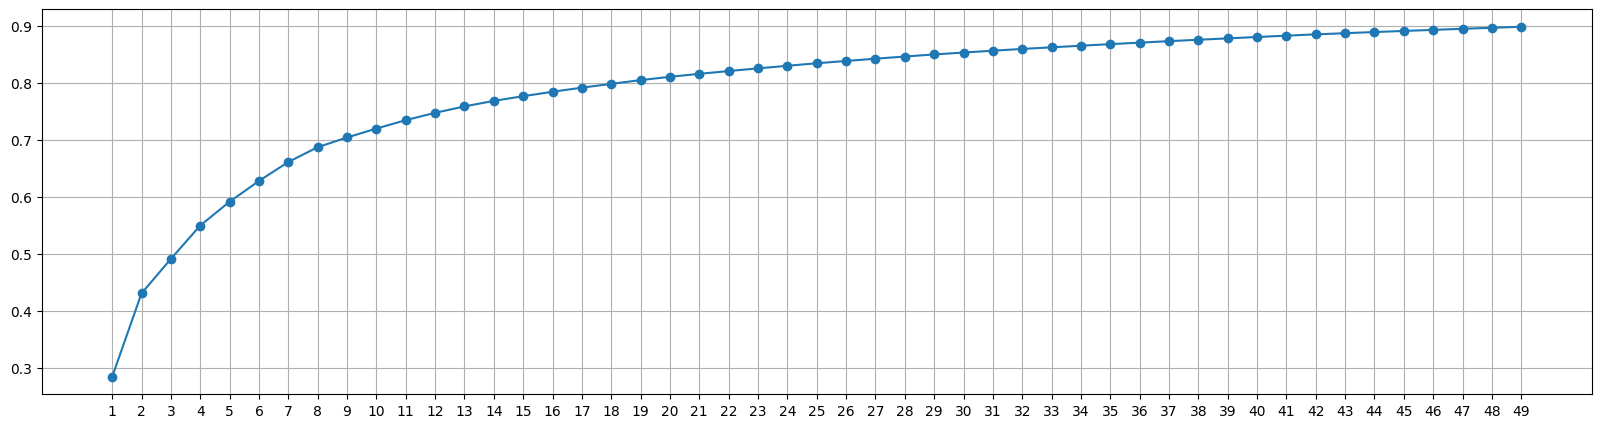

In [ ]:
from cuml.decomposition import PCA

variances = []

for k in range(1, 50):
    pca = PCA(n_components=k)
    pca.fit(embeddings)

    variances.append(pca.explained_variance_ratio_.sum().get())

    if pca.explained_variance_ratio_.sum().get() > 0.95:
        print(f"95% variance explained with {k} components")
        break

plt.figure(figsize=(20, 5))
plt.grid(True)
plt.title("Variance Explained by PCA Components")
plt.xticks(range(1,50))
plt.plot(range(1,50), variances, marker='o')
plt.show()

In [12]:
from cuml.cluster import DBSCAN, KMeans

kmeans = KMeans(n_clusters=10, random_state=0)

dbscan = DBSCAN(eps=0.5, min_samples=5)

dbscan_clusters = dbscan.fit_predict(embeddings)

kmeans_clusters = kmeans.fit_predict(embeddings)

/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


/home/ibrahim/anaconda3/envs/rapids/lib/python3.12/site-packages/cuml/internals/api_decorators.py:405: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[2025-04-08 17:16:16.799] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


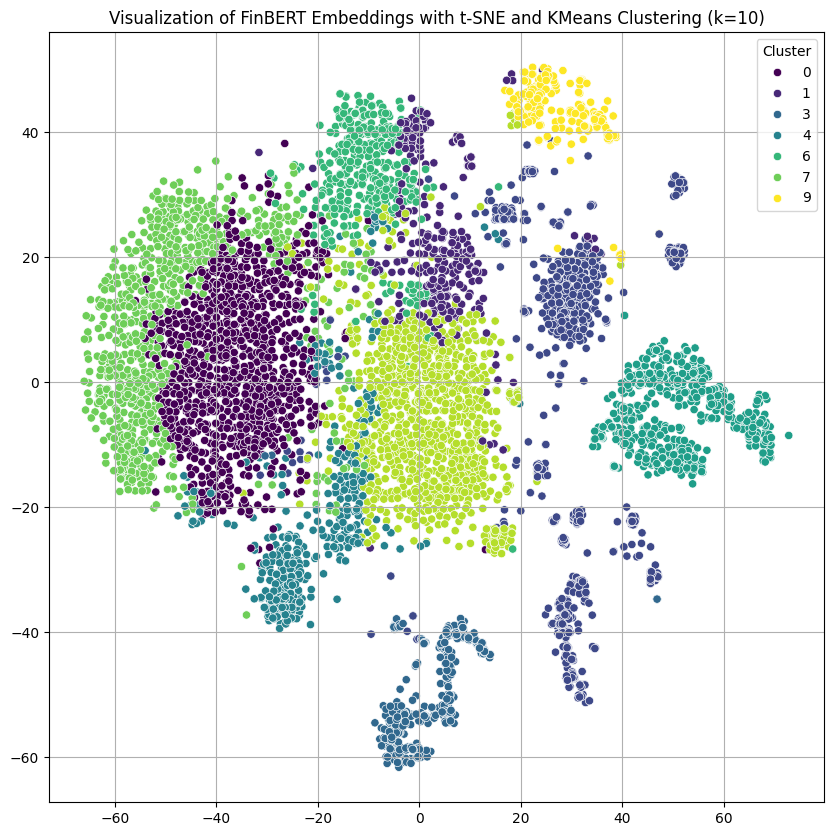

In [14]:
from cuml.decomposition import PCA
from cuml.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, perplexity=50, n_neighbors=500, n_iter=2000, init="pca")
tsne_embeddings = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 10))
plt.title("Visualization of FinBERT Embeddings with t-SNE and KMeans Clustering (k=10)")
sns.scatterplot(x=tsne_embeddings[:, 0].get(), y=tsne_embeddings[:, 1].get(), hue=kmeans_clusters.get(), palette="viridis")
plt.grid(True)
plt.legend(title="Cluster")
plt.savefig(os.path.join(PLOTS_DIR, "kmeans_tsne.png"))

In [8]:
corpus["2020"]["news_tfidf"].toarray().shape

KeyError: 'news_tfidf'